# TRAJECTORY PREDICTION AND COLLISION DETECTION

This notebook corresponds to Jokin Cuesta's Master's Thesis for the Master's Degree in Data Science at the UOC. In this notebook, different ML algorithms will be studied using multi-step strategy in order to predict the trajectory of vehicles, as well as to predict collisions.

Some of the code is inspired in Rafael Corvillo´s thesis (https://github.com/rcorvial/vehicles_collision_detector). This code is referenced in each cell as (RC)

# 1. Importing libraries

First of all, we will import all the libraries used in this notebook:

In [1]:
!pip install haversine
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import haversine as hs
from haversine import Unit
import math
from google.colab import drive
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker

# 2. Data upload


We will upload the datasets needed.

In [12]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [13]:
# Load scaled dataset
DATASETS_FOLDER = os.path.join("TFM", "datasets")
SCALED_FILE = os.path.join(DATASETS_FOLDER, "scaled_dataset.csv")
df = pd.read_csv(SCALED_FILE)

# Load dataset with vehicles colision
DATASET_COL = os.path.join(DATASETS_FOLDER, "collision.csv")
df_col = pd.read_csv(DATASET_COL)
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)

# Load dataset with vehicles no-colision
DATASET_NOCOL = os.path.join(DATASETS_FOLDER, "no_collision.csv")
df_nocol = pd.read_csv(DATASET_NOCOL)
df_nocol = df_nocol[['v1', 'v2']].astype(int)

# Load dataset with dimensions
DATASET_DIM = os.path.join(DATASETS_FOLDER, "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id','length','width']]

In [14]:
# (RC)
from sklearn.preprocessing import MinMaxScaler
import pickle
# Load MinMaxScaler for target variables
MINMAXSCALER_FILE = os.path.join("TFM", "implementation",
                                 "data_preparation", "minmaxscaler.pkl")
with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
  minmaxscaler = pickle.load(f_minmaxscaler)

In [15]:
# Group the DataFrame by 'id' and count the number of records for each 'id'
id_counts = df['vehicle_id'].value_counts()

# Get the ID with the maximum number of records
max_id = id_counts.idxmax()

# Print the ID with the maximum number of records
print("ID with the maximum number of records:", max_id)

ID with the maximum number of records: 4443


In [16]:
# Obtain the required columns for each sample for collisions
col_values = df_col[["vehicle_id", "victim_id"]].values.tolist()
nocol_values = df_nocol[["v1", "v2"]].values.tolist()

# Combines the values of both DataFrames in a list
combined_pairs = col_values + nocol_values
print(len(combined_pairs))

2000


In [17]:
# Obtain the required columns for each sample for no collisions
col_values = df_col[["vehicle_id", "victim_id"]].values.flatten().tolist()
nocol_values = df_nocol[["v1", "v2"]].values.flatten().tolist()

# Combina los valores de ambos DataFrames en una lista
combined_values = col_values + nocol_values

# Imprimir la lista de ID-s únicos
print("ID-s únicos:")
print(len(combined_values))

ID-s únicos:
4000


To use ML models, we must choose a number of coordinates with which we will train the models. Let's see with a test (id = 9863) with which number of records we get the best results.

In [18]:
from sklearn.linear_model import LinearRegression

vehicle_train = df[df['vehicle_id']==9863].iloc[:-5]
vehicle_test = df[df['vehicle_id']==9863].iloc[-5:]
dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)']])
dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)']])
hsp=[]
for i in range (1, len(vehicle_train)-1):
  raw= dat_train[i:len(vehicle_train)]
  X = raw[:-1]
  y = raw[1:]
  model = LinearRegression()
  # Train the model
  model.fit(X, y)
  # Try to predict next step
  pred=model.predict([raw[-1]])
  # The predicted value [414051933,  21776806] and the true value would be [414051935,21776785], not so far
  hsp.append([i,hs.haversine(( pred[0,0] , pred[0,1] ),( dat_train[i,0] , dat_train[i,1] ), unit=Unit.METERS)])

In [19]:
# extract the values of 'x' and 'y' in separate lists
x_values = [row[0] for row in hsp]
y_values = [row[1] for row in hsp]

# find the index of the minimum value of 'y'.
min_y_index = y_values.index(min(y_values))

# find the value of 'x' corresponding to the index of the minimum value of 'y'.
min_x_value = x_values[min_y_index]
print("El valor de 'x' correspondiente al mínimo valor de 'y' es:", min_x_value)

El valor de 'x' correspondiente al mínimo valor de 'y' es: 73


Now we plot the results.

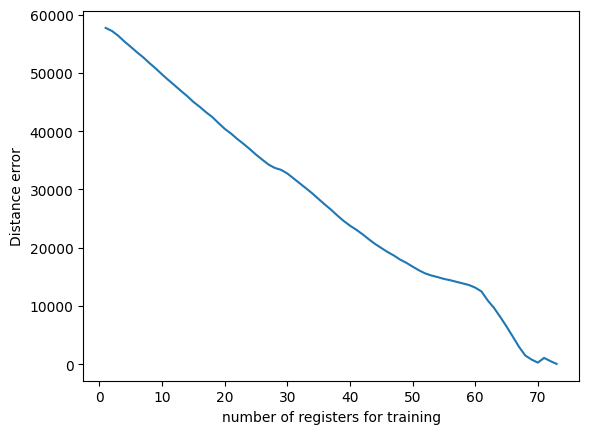

In [20]:
# Plot
fig, ax = plt.subplots()
ax.plot(x_values, y_values)
ax.set_xlabel('number of registers for training')
ax.set_ylabel('Distance error')
plt.show()

It can be seen that the higher the number of registrations, the better the results.

# 3. Trajectory Prediction

To predict trajectories, we will divide the dataset into two parts, one removing the last 5 records (dat_train) and the last 5 records (dat_test) to test the results obtained.

The idea is in each iteration:
- Choose some training samples (num). This time we will choose 100, to have a balance between the results obtained and the training time.
- With the trained model predict one step (one sample) from the last training sample.
- If you want to predict X steps in the future, you do the same as in the previous step, but the second prediction uses the previous predicted sample.
- The error is calculated with the haversine function to know the distance in metres between the actual and the predicted position.

We will do an example with the id = 9863 and a Linear Regression with 15 number of registers to get a better undestanding of the methodology.

The code to build the functions of trajectory prediction (fit_and_pred)is based on the one given by Raul Parada Medina, tutor of the thesis.

### Prediction first second.  Test id = 9863




In [ ]:
from sklearn.linear_model import LinearRegression
id = 9863

# We get the train and test data
vehicle_train = df[df['vehicle_id']==id].iloc[:-5]
vehicle_test = df[df['vehicle_id']==id].iloc[-5:]
dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)', 'heading']])
dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)', 'heading']])
NUM = 15
model = LinearRegression()
# Divide X and y
raw1= dat_train[-NUM:len(vehicle_train)]
X = raw1[:-1]
y = raw1[1:]

# Train the model
model.fit(X, y)
# Try to predict next step
pred=model.predict([raw1[-1]])

pred_scaled = minmaxscaler.inverse_transform(pred.reshape(-1, 3))
dat_test[0] = minmaxscaler.inverse_transform(dat_test[0].reshape(-1, 3))
print("The predicted coordinates are: {}, {}".format(pred_scaled[0,0],pred_scaled[0,1]))
# The predicted value [x,  y], now the error:
print("The distance between the predicted coords and the real ones is: {:.3f} meters".format(hs.haversine(( pred_scaled[0,0] , pred_scaled[0,1] ), (dat_test[0,0] , dat_test[0,1]), unit=Unit.METERS)))

The predicted coordinates are: 41.39196129067444, 2.1651858686634924
The distance between the predicted coords and the real ones is: 0.944 meters


### Prediction second 2

In [ ]:
# for second 2 we add the last prediction to the array
raw2 = np.vstack([raw1[:-1],pred])
X = raw2[:-1]
y = raw2[1:]

# Train the model
model.fit(X, y)
# Try to predict next step
pred2=model.predict([raw2[-1]])

pred_scaled2 = minmaxscaler.inverse_transform(pred2.reshape(-1, 3))
dat_test[1] = minmaxscaler.inverse_transform(dat_test[1].reshape(-1, 3))

print("The predicted coordinates are: {}, {}".format(pred_scaled2[0,0],pred_scaled2[0,1]))
print("The distance between the predicted coords and the real ones is: {:.3f} meters".format(hs.haversine(( pred_scaled2[0,0] , pred_scaled2[0,1] ), (dat_test[1,0] , dat_test[1,1]), unit=Unit.METERS)))

The predicted coordinates are: 41.39198006455492, 2.165162335410112
The distance between the predicted coords and the real ones is: 1.420 meters


### Prediction second 3

In [ ]:
# for second 3 we add the last prediction to the array
raw3 = np.vstack([raw2,pred2])
X = raw3[:-1]
y = raw3[1:]

# Train the model
model.fit(X, y)

# Try to predict next step
pred3=model.predict([raw3[-1]])
pred_scaled3 = minmaxscaler.inverse_transform(pred3.reshape(-1, 3))
dat_test[2] = minmaxscaler.inverse_transform(dat_test[2].reshape(-1, 3))
print("The predicted coordinates are: {}, {}".format(pred3[0,0],pred3[0,1]))
print("The distance between the predicted coords and the real ones is: {:.3f} meters".format(hs.haversine(( pred_scaled3[0,0] , pred_scaled3[0,1] ), (dat_test[2,0] , dat_test[2,1]), unit=Unit.METERS)))

The predicted coordinates are: 0.7002471917141398, 0.7499292332567344
The distance between the predicted coords and the real ones is: 0.344 meters


### Predicción segundo 4

In [ ]:
# for second 4 we add the last prediction to the array
raw4 = np.vstack([raw3,pred3])
X = raw4[:-1]
y = raw4[1:]

# Train the model
model.fit(X, y)
# Try to predict next step
pred4=model.predict([raw4[-1]])
pred_scaled4 = minmaxscaler.inverse_transform(pred4.reshape(-1, 3))
dat_test[3] = minmaxscaler.inverse_transform(dat_test[3].reshape(-1, 3))
print("The predicted coordinates are: {}, {}".format(pred_scaled4[0,0],pred_scaled4[0,1]))
print("The distance between the predicted coords and the real ones is: {:.3f} meters".format(hs.haversine(( pred_scaled4[0,0] , pred_scaled4[0,1] ), (dat_test[3,0] , dat_test[3,1]), unit=Unit.METERS)))

The predicted coordinates are: 41.39200999679489, 2.165125702617621
The distance between the predicted coords and the real ones is: 3.821 meters


### Predicción segundo 5

In [ ]:
# for second 5 we add the last prediction to the array
raw5 = np.vstack([raw4,pred4])
X = raw4[:-1]
y = raw4[1:]

# Train the model
model.fit(X, y)
# Try to predict next step
pred5=model.predict([raw5[len(raw5)-1]])
pred_scaled5 = minmaxscaler.inverse_transform(pred5.reshape(-1, 3))
dat_test[4] = minmaxscaler.inverse_transform(dat_test[4].reshape(-1, 3))
print("The predicted coordinates are: {}, {}".format(pred5[0,0],pred5[0,1]))
print("The distance between the predicted coords and the real ones is: {:.3f} meters".format(hs.haversine(( pred_scaled5[0,0] , pred_scaled5[0,1] ), (dat_test[4,0] , dat_test[4,1]), unit=Unit.METERS)))

The predicted coordinates are: 0.7038748597362128, 0.7466270651988639
The distance between the predicted coords and the real ones is: 9.618 meters


We can choose how many seconds we want to predict. We also will use the heading to improve the predictions.

In [ ]:
# Make the new predictions
from sklearn.linear_model import LinearRegression
model = LinearRegression()
t = 5
vehicle_train = df[df['vehicle_id']==9863].iloc[:-t]
vehicle_test = df[df['vehicle_id']==9863].iloc[-t:]
dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)','heading']])
dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)','heading']])

NUM = 15
raw= dat_train[-NUM:]
model = LinearRegression()
# Try to predict next step
for i in range(t):
  X = raw[:-1]
  y = raw[1:]
  # Train the model
  model.fit(X, y)
  # Make predictions
  pred=model.predict([raw[len(raw)-1]])
  raw = np.vstack([raw,pred])
  pred_scaled = minmaxscaler.inverse_transform(pred.reshape(-1, 3))
  print("The predicted for second {} coordinates are: {}, {}".format(i+1,
                                            pred_scaled[0,0],pred_scaled[0,1]))
dat_test[4] = minmaxscaler.inverse_transform(dat_test[4].reshape(-1, 3))
print("---------------------------------------------------------------------------------\n The distance between the predicted coords and the real ones is: {:.3f} meters"
.format(hs.haversine(( pred_scaled[0,0] , pred_scaled[0,1] ), (dat_test[4,0] , dat_test[4,1]), unit=Unit.METERS)))

The predicted for second 1 coordinates are: 41.39196129067444, 2.1651858686634924
The predicted for second 2 coordinates are: 41.39197707295208, 2.165166101307283
The predicted for second 3 coordinates are: 41.39199031335503, 2.165149950185529
The predicted for second 4 coordinates are: 41.39200172408894, 2.1651360123904553
The predicted for second 5 coordinates are: 41.39201155557435, 2.1651239981647934
---------------------------------------------------------------------------------
 The distance between the predicted coords and the real ones is: 11.182 meters


So we define a function that predicts for t seconds the coordinates of the vehicle, with the number of registers and the model we want.

In [ ]:
from sklearn.linear_model import LinearRegression
def fit_and_pred(num, t, model, array):
  """
  Perform fitting and prediction using the specified model.

  Parameters:
  - num (int): Number of previous data points to consider for predictions.
  - t (int): Number of steps to predict into the future.
  - model: The machine learning model object with fit and predict methods.
  - array: The input array of data points.

  Returns:
  - np.array: An array containing the predicted values for the next t steps.
  """
  preds = []
  raw = array[-num:]
  # Predict nex num steps:
  for i in range(t):
      X = raw[:-1]
      y = raw[1:]
      model.fit(X, y)
  # Train the model
      pred=model.predict([raw[-1]])
      preds.append(pred)  # Agregar pred a la lista de preds
      raw = np.vstack([raw,pred])

  return np.array(preds)

# 4. Collision prediction

In this first step, we will create a model (linear, RANSAC etc.) to predict the position (lat,lon,heading) in which the vehicle will be located over the 5 seconds.

To evaluate the model, we will calculate the distance between the predicted and the actual position. We will apply the model to all id-s and calculate the average distance for the different selected models.

## 4.2 Collision prediction functions

### 4.2.1. Geometric functions (Code from Raúl Parada)

In [21]:
import pandas as pd
import numpy as np
import haversine as hs
from haversine import Unit
from sklearn.linear_model import Lars
import math
import geopy
import geopy.distance
import math
import folium
from shapely import geometry, ops
import time

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
  """
  Calculates the bearing between two geographic coordinates.

  Args:
      a_lat (float): Latitude of the previous position.
      a_lon (float): Longitude of the previous position.
      b_lat (float): Latitude of the current position.
      b_lon (float): Longitude of the current position.

  Returns:
      float: The bearing in degrees.

  The bearing is the direction from the previous position (a) to the current position (b),
  measured clockwise from north.

  Note: This function assumes that the input coordinates are in decimal degrees.

  """
  rlat1 = math.radians(a_lat)
  rlon1 = math.radians(a_lon)
  rlat2 = math.radians(b_lat)
  rlon2 = math.radians(b_lon)
  dlon = math.radians(b_lon - a_lon)
  b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
  bd = math.degrees(b)
  br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
  return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
  """
  Calculates the coordinates of the points of a rotated rectangle.

  Args:
      coordinates (tuple): The latitude and longitude coordinates (in decimal degrees) of the center point of the rectangle.
      bearing (float): The bearing (direction) in degrees at which the rectangle should be rotated.
      width (float): The width of the rectangle in kilometers.
      length (float): The length of the rectangle in kilometers.

  Returns:
      list: A list of tuples representing the latitude and longitude coordinates of the points of the rotated rectangle.

  The function takes the center coordinates of a rectangle, a bearing (direction) in degrees, and the width and length of the rectangle in kilometers.
  It calculates the coordinates of the points of the rectangle after it has been rotated by the specified bearing.

  The function uses the geopy library to perform distance and bearing calculations.

  Note: The width and length should be provided in kilometers, and the coordinates should be in decimal degrees.

  """
  start = geopy.Point(coordinates)
  width = width/1000
  length = length/1000
  rectlength = geopy.distance.distance(kilometers=length)
  rectwidth = geopy.distance.distance(kilometers=width)
  halfwidth = geopy.distance.distance(kilometers=width/2)
  halflength = geopy.distance.distance(kilometers=length/2)

  pointAB = halflength.destination(point=start, bearing=bearing)
  pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
  pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
  pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
  pointD = rectwidth.destination(point=pointC, bearing = 0 - bearing)

  points = []
  for point in [pointA, pointB, pointC, pointD]:
    coords = (point.latitude, point.longitude)
    points.append(coords)

  return points

### 4.2.2 Collision prediction function

In [22]:
### Based on RC
def get_collision(model, num, t, id1, dat_train1, id2, dat_train2, dimensions):
  """
  Checks for a collision between two vehicles using prediction models.

  Args:
      model: The prediction model to use.
      num: Number of steps to consider for backward predictions.
      t: Number of steps to predict forward.
      id1: ID of the first vehicle.
      dat_train1: Training data for the first vehicle.
      id2: ID of the second vehicle.
      dat_train2: Training data for the second vehicle.
      dimensions: DataFrame with vehicle dimensions.

  Returns:
      collision: Binary value (0 or 1) indicating whether a collision was detected."""
  collision = 0
  # v1 dimensiones
  v1_length = dimensions[dimensions['vehicle_id'] == id1].iloc[0, 1]
  v1_width = dimensions[dimensions['vehicle_id'] == id1].iloc[0, 2]

  # v2 dimensiones
  v2_length = dimensions[dimensions['vehicle_id'] == id2].iloc[0, 1]
  v2_width = dimensions[dimensions['vehicle_id'] == id2].iloc[0, 2]

  #models
  model1 = model
  model2 = model

  # we predicts v1 y v2
  pred_coor1 = fit_and_pred(num, t, model1, dat_train1)
  pred_coor2 = fit_and_pred(num, t, model2, dat_train2)

  # we need pred_coord1[-1] and [-2]
  coor_scale11 = minmaxscaler.inverse_transform(pred_coor1[-1][0].reshape(-1, 3))
  coor_scale12 = minmaxscaler.inverse_transform(pred_coor1[-2][0].reshape(-1, 3))
  print(coor_scale11)
  print(coor_scale11)
  # we need pred_coord2[-1] and [-2]
  coor_scale21 = minmaxscaler.inverse_transform(pred_coor2[-1][0].reshape(-1, 3))
  coor_scale22 = minmaxscaler.inverse_transform(pred_coor2[-2][0].reshape(-1, 3))

  # Calculate the bearing
  bearing_v1 = bearing_calc(coor_scale12[0,0], coor_scale12[0,1],coor_scale11[0,0],
                            coor_scale11[0,1]) # a previous position b current position
  bearing_v2 = bearing_calc(coor_scale22[0,0], coor_scale22[0,1],coor_scale21[0,0],
                            coor_scale21[0,1]) # a previous position b current position


  # Calculate the points
  v1_points = get_rotated_points(tuple(coor_scale11[0][:2]),
                                 bearing_v1, v1_width, v1_length) #(coordinates, bearing, width, length)
  v2_points = get_rotated_points(tuple(coor_scale21[0][:2]),
                                 bearing_v2, v2_width, v2_length) #(coordinates, bearing, width, length)
  polygon1 = geometry.Polygon(v1_points)
  polygon2 = geometry.Polygon(v2_points)

  # Collision or not
  if polygon1.intersects(polygon2):
    collision = 1
  return (collision)

### 4.2.3 Evaluation metrics

We will obtain metrics for calculating the performance of the function

In [23]:
# (Based on RC)
def get_metrics(model, num,t, df_col, df_nocol, df_dim):
  """
  Calculates evaluation metrics for a collision detection model.

  Args:
      model (object): The collision detection model.
      num (int): Number of instances to sample from the data.
      t (int): Number of recent data points to consider for testing.
      df_col (DataFrame): DataFrame containing pairs of vehicles that collide.
      df_nocol (DataFrame): DataFrame containing pairs of vehicles that do not collide.
      df_dim (DataFrame): DataFrame containing dimensional data.

  Returns:
      None

  Prints the following evaluation metrics:
      - Total collisions
      - True positives
      - False negatives
      - Total non-collisions
      - False positives
      - True negatives
      - Accuracy
      - Precision
      - Recall
      - F1 Score
      - Specificity

  Note: Uncomment the code within the function to write the metrics to a file instead of printing.

  """
  total_colission = 0
  total_no_colission = 0
  error_ids = []

  true_positive = 0
  false_negative = 0
  false_positive = 0
  true_negative = 0


   # Obtain the values of each column
  col_values = df_col[["vehicle_id", "victim_id"]].values.tolist()
  nocol_values = df_nocol[["v1", "v2"]].values.tolist()

  # Collisions.
  for id1,id2 in col_values:
    # Train1
    vehicle_train1 = df[df['vehicle_id']==id1].iloc[:-t]
    vehicle_test1 = df[df['vehicle_id']==id1].iloc[-t:]
    # np array1
    dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
    dat_test1 = np.array(vehicle_test1[['latitude(m)','longitude(m)','heading']])

    # Train2
    vehicle_train2 = df[df['vehicle_id']==id2].iloc[:-t]
    vehicle_test2 = df[df['vehicle_id']==id2].iloc[-t:]

    # np array2
    dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
    dat_test2 = np.array(vehicle_test2[['latitude(m)','longitude(m)','heading']])
    total_colission += 1
    try:
      if get_collision(model,num, t, id1,dat_train1, id2, dat_train2, df_dim): #model, num, t, id1, dat_train1, id2, dat_train2, dimensions
        true_positive += 1
      else:
        false_negative += 1
    except ValueError:
      false_negative += 1

  # Non-collisions
  for id1,id2 in nocol_values:
    # Train1
    vehicle_train1 = df[df['vehicle_id']==id1].iloc[:-t]
    vehicle_test1 = df[df['vehicle_id']==id1].iloc[-t:]
    # np array1
    dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)']])
    dat_test1 = np.array(vehicle_test1[['latitude(m)','longitude(m)']])

    # Train2
    vehicle_train2 = df[df['vehicle_id']==id2].iloc[:-t]
    vehicle_test2 = df[df['vehicle_id']==id2].iloc[-t:]

    # np array2
    dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)']])
    dat_test2 = np.array(vehicle_test2[['latitude(m)','longitude(m)']])
    total_no_colission += 1
    try:
      if get_collision(model,num, t, id1,dat_train1, id2, dat_train2, df_dim): #model, num, t, id1, dat_train1, id2, dat_train2, dimensions
        false_positive += 1
      else:
        true_negative += 1
    except ValueError:
      true_negative += 1


  accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
  precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
  recall = true_positive/(true_positive+false_negative)
  F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
  specificity = true_negative/(true_negative+false_positive)

  print("Total colision: {}".format(total_colission))
  print("TP: {}".format(true_positive))
  print("FN: {}".format(false_negative))
  print("Total no colision: {}".format(total_no_colission))
  print("FP: {}".format(false_positive))
  print("TN: {}".format(true_negative))
  print()
  print("Accuracy: {}".format(accuracy))
  print("Precision: {}".format(precision))
  print("Recall: {}".format(recall))
  print("F1 Score: {}".format(F1_score))
  print("Specificity: {}".format(specificity))

In [24]:
# Distance metrics
def extract_lat_lon(arr):
    lat_lon = []
    for item in arr:
        lat_lon.append([item[0][0], item[0][1]])
    return np.array(lat_lon)


def mae(y_true, y_pred):
    """
    Calculates the Mean Absolute Error (MAE).

    Parameters:
    - y_true: np.array or list. True values.
    - y_pred: np.array or list. Predicted values.

    Returns:
    - float. The MAE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true_latlon = extract_lat_lon(y_true)
    y_pred_latlon = extract_lat_lon(y_pred)
    mae_score = np.mean(np.abs(y_true_latlon - y_pred_latlon))

    return mae_score


def mse(y_true, y_pred):
    """
    Calcula el Error Cuadrático Medio (MSE) para coordenadas de latitud y longitud.

    Parámetros:
    - y_true: np.array o lista de tuplas (lat, lon). Valores reales.
    - y_pred: np.array o lista de tuplas (lat, lon). Valores predichos.

    Retorna:
    - float. El valor del MSE.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true_latlon = extract_lat_lon(y_true)
    y_pred_latlon = extract_lat_lon(y_pred)

    mse_score = np.mean((y_true_latlon - y_pred_latlon)**2)

    return mse_score



def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) for latitude and longitude.

    Parameters:
    - y_true: np.array or list. True values.
    - y_pred: np.array or list. Predicted values.

    Returns:
    - float. The SMAPE value.
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true_latlon = extract_lat_lon(y_true)
    y_pred_latlon = extract_lat_lon(y_pred)

    numerator = np.abs(y_true_latlon - y_pred_latlon)
    denominator = (np.abs(y_true_latlon) - np.abs(y_pred_latlon)) / 2.0

    smape_score = np.mean(numerator / denominator) * 100

    return smape_score


def fde(y_true, y_pred):
    """
    Calculates the Final Displacement Error (FDE).

    Parameters:
    - y_true: np.array or list. True values of the final positions.
    - y_pred: np.array or list. Predicted values of the final positions.

    Returns:
    - float. The FDE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true_latlon = extract_lat_lon(y_true)
    y_pred_latlon = extract_lat_lon(y_pred)

    fde_score = np.mean(np.linalg.norm(y_true_latlon - y_pred_latlon, axis=1))

    return fde_score

In [25]:
import warnings

from haversine import haversine, Unit

def calc_dist(model, t, num, combined_values):
  """
  Calculate distances and statistics between predicted and real positions.

  Parameters:
  - model: The predictive model used for position prediction.
  - t: The number of time steps to predict.
  - num: The number of training samples to use for prediction.
  - combined_values: A list of vehicle IDs for which to calculate distances.

  Returns: None
  """
  tracker = EmissionsTracker(log_level="error")
  # Ignore all warnings
  warnings.filterwarnings("ignore")

  inicio = time.time()  # Capture the initial time
  tracker.start()
  # List to store all distances
  distances = [[] for _ in range(t)]
  # List to store IDs that produce out-of-range coordinate errors
  error_ids = [[] for _ in range(t)]
  # y_true
  y_true = [[] for _ in range(t)]
  # y_pred
  y_pred = [[] for _ in range(t)]

  # Iterate over IDs and call predict_position function for each one
  for id in combined_values:
    # Training
    vehicle_train = df[df['vehicle_id']==id].iloc[:-t]
    vehicle_test = df[df['vehicle_id']==id].iloc[-t:]
    # np array
    dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)','heading']])
    dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)','heading']])
    coor = fit_and_pred(num, t, model, dat_train)
    for i in range(t):
      coor_scale = minmaxscaler.inverse_transform(coor[i].reshape(-1, 3))
      dat_test_scale = minmaxscaler.inverse_transform(dat_test[i].reshape(-1, 3))
      y_pred[i].append(coor_scale)
      y_true[i].append(dat_test_scale)
      try:
        dist = haversine((( coor_scale[0,0]) , coor_scale[0,1] ), (dat_test_scale[0,0] , dat_test_scale[0,1]), unit=Unit.METERS)
        #print(f"ID: {id}, Distance error: {dist}")
        if dist > 100:
          error_ids[i].append(id)
        elif dist < 100:
          distances[i].append(dist)
      except ValueError:
        error_ids[i].append(id)

  # Execution time
  fin = time.time()  # Capture the final time
  emissions = tracker.stop()
  for i in range(t):
    print("===================== t = {}s =============================".format(i+1))
    # Print the IDs that produced errors
    print("Number of IDs out of range: {}".format(len(error_ids[i])))
    # Calculate the mean of distances
    mean_distance = sum(distances[i]) / len(distances[i])
    # Print the mean of distances
    print("Average of distances error: {:.2f}m".format(mean_distance))
    # Print the percentage of out-of-range
    print("Percentage out of range: {:.2f}%".format(len(error_ids[i])/len(combined_values)*100))
    if i == t-1:
      print("===================== METRICS =============================")
      # MAE
      #mae_distance = mae(y_true[-1], y_pred[-1])
      #print("MAE: {}".format(mae_distance))

      #MSE
      #mse_distance = mse(y_true[i], y_pred[i])
      #print("MSE: {}".format(mse_distance))

      # SMAPE
      #smape_distance = smape(y_true[i], y_pred[i])
      #print("SMAPE: {}".format(smape_distance))

      # FDE
      #fde_distance = fde(y_true[i], y_pred[i])
      #print("FDE: {}".format(fde_distance))

  tiempo_ejecucion = fin - inicio  # Calcular el tiempo transcurrido
  print("Execution time: {:.2f} seconds".format(tiempo_ejecucion))
  print("Emissions (kg): {:.5f}\n".format(emissions))

#5. Regression ML Models

To test the model, we are going to use pairs of vehicles. 1000 records have been selected from the collision datasets and another 1000 from time-matched vehicles.

## Individual 5.1 ML models

### 5.1.1 Linear Regression

To predict the position of the vehicles, we have their latitude and longitude coordinates. We will use a part of the df to train the model and the last 3 records to evaluate the actual and predicted distance after 3 seconds.

We try with linear function.

In [ ]:
t = 5
NUM = 50
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
ID = 3

# Train
vehicle_train = df[df['vehicle_id']==ID].iloc[:-t]
vehicle_test = df[df['vehicle_id']==ID].iloc[-t:]

dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)','heading'	]])
dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)','heading']])

# Wr obtain the coordinates
coor = fit_and_pred(NUM, t, linear, dat_train)
dist = []
for i in range(t):
  coor_scale = minmaxscaler.inverse_transform(coor[i].reshape(-1, 3))
  dat_test_scale = minmaxscaler.inverse_transform(dat_test[i].reshape(-1, 3))
  dist.append(hs.haversine((( coor_scale[0,0]) , coor_scale[0,1] ), (dat_test_scale[0,0] , dat_test_scale[0,1]), unit=Unit.METERS))

# Create a df with the results
df_dist = pd.DataFrame({'t': range(1, 6), 'Distance Error': dist})
df_dist.style.set_properties(subset=['t'], **{'text-align': 'center'})
df_dist.style.set_properties(subset=['Resultado'], **{'text-align': 'right'})
df_dist.style.set_table_styles([{'selector': 'th', 'props': [('width', '80px')]}])
df_dist.style.format({'Resultado': '{:.2f}'})

# Mostrar el DataFrame como tabla
print(df_dist.to_string(index=False))

 t  Distance Error
 1        0.009408
 2        0.027344
 3        0.057236
 4        0.089755
 5        0.121167


In [ ]:
t = 5
NUM = 100
linear = LinearRegression()

# Train
vehicle_train = df[df['vehicle_id']==ID].iloc[:-t]
vehicle_test = df[df['vehicle_id']==ID].iloc[-t:]

dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)','heading']])
dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)','heading']])

#We obtain the coordinates
coor = fit_and_pred(NUM, t, linear, dat_train)
dist = []
for i in range(t):
  coor_scale = minmaxscaler.inverse_transform(coor[i].reshape(-1, 3))
  dat_test_scale = minmaxscaler.inverse_transform(dat_test[i].reshape(-1, 3))
  dist.append(hs.haversine((( coor_scale[0,0]) , coor_scale[0,1] ), (dat_test_scale[0,0] , dat_test_scale[0,1]), unit=Unit.METERS))

# Create a df with the results
df_dist = pd.DataFrame({'t': range(1, 6), 'Distance Error': dist})
df_dist.style.set_properties(subset=['t'], **{'text-align': 'center'})
df_dist.style.set_properties(subset=['Resultado'], **{'text-align': 'right'})
df_dist.style.set_table_styles([{'selector': 'th', 'props': [('width', '80px')]}])
df_dist.style.format({'Resultado': '{:.2f}'})

# Mostrar el DataFrame como tabla
print(df_dist.to_string(index=False))

 t  Distance Error
 1        0.026579
 2        0.055812
 3        0.085507
 4        0.114519
 5        0.142277


Now we try with the function calc_dist

### Linear Regression

In [ ]:
linear = LinearRegression()
t = 5
NUM = 100
calc_dist(linear,t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 43
Average of distances error: 2.86m
Percentage out of range: 1.07%
===================== t = 2s =============================
Number of IDs out of range: 111
Average of distances error: 5.79m
Percentage out of range: 2.77%
===================== t = 3s =============================
Number of IDs out of range: 119
Average of distances error: 9.18m
Percentage out of range: 2.97%
===================== t = 4s =============================
Number of IDs out of range: 158
Average of distances error: 12.40m
Percentage out of range: 3.95%
===================== t = 5s =============================
Number of IDs out of range: 180
Average of distances error: 15.91m
Percentage out of range: 4.45%
===================== METRICS =============================
Execution time: 158.09 seconds
Emissions (kg):  0.00094


### SVR

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
svr = SVR()
mor = MultiOutputRegressor(svr)
t = 5
NUM = 100
calc_dist(mor,t, NUM, combined_values)

===================== t = 1s =============================
IDs con coordenadas fuera de rango: 434
Average of distances error: 63.89m
Percentage out of range: 10.85%
===================== t = 2s =============================
IDs con coordenadas fuera de rango: 854
Average of distances error: 63.45m
Percentage out of range: 21.35%
===================== t = 3s =============================
IDs con coordenadas fuera de rango: 1166
Average of distances error: 61.91m
Percentage out of range: 29.15%
===================== t = 4s =============================
IDs con coordenadas fuera de rango: 1388
Average of distances error: 60.86m
Percentage out of range: 34.70%
===================== t = 5s =============================
IDs con coordenadas fuera de rango: 1530
Average of distances error: 60.30m
Percentage out of range: 38.25%
===================== METRICS =============================
Execution time: 202.43 seconds
Emissions (kg):  0.00121


### RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=2, random_state=0)
t = 5
NUM = 100
calc_dist(rf,t, NUM, combined_values)

===================== t = 1s =============================
IDs con coordenadas fuera de rango: 354
Average of distances error: 33.16m
Percentage out of range: 8.85%
===================== t = 2s =============================
IDs con coordenadas fuera de rango: 515
Average of distances error: 35.80m
Percentage out of range: 12.88%
===================== t = 3s =============================
IDs con coordenadas fuera de rango: 639
Average of distances error: 36.86m
Percentage out of range: 15.97%
===================== t = 4s =============================
IDs con coordenadas fuera de rango: 745
Average of distances error: 37.54m
Percentage out of range: 18.62%
===================== t = 5s =============================
IDs con coordenadas fuera de rango: 819
Average of distances error: 38.54m
Percentage out of range: 20.47%
===================== METRICS =============================
MAE: 0.0004244192382772873
MSE: 3.6096025285476116e-07
SMAPE: 0.011738921239478901
FDE: 0.0006344803829302633
E

### RANSACRegressor

In [ ]:
from sklearn.linear_model import RANSACRegressor
t = 5
NUM = 100
ransac = RANSACRegressor(loss='squared_error', max_trials=20, stop_probability=0.0)
calc_dist(ransac,t, NUM, combined_values)

===================== t = 1s =============================
IDs con coordenadas fuera de rango: 546
Average of distances error: 5.08m
Percentage out of range: 13.65%
===================== t = 2s =============================
IDs con coordenadas fuera de rango: 1082
Average of distances error: 9.65m
Percentage out of range: 27.05%
===================== t = 3s =============================
IDs con coordenadas fuera de rango: 1548
Average of distances error: 12.95m
Percentage out of range: 38.70%
===================== t = 4s =============================
IDs con coordenadas fuera de rango: 1840
Average of distances error: 17.05m
Percentage out of range: 46.00%
===================== t = 5s =============================
IDs con coordenadas fuera de rango: 2110
Average of distances error: 20.28m
Percentage out of range: 52.75%
===================== METRICS =============================
Execution time: 249.82 seconds
Emissions (kg): 0.00148


### GAUSSIAN REGRESSOR

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
t = 5
NUM = 100
gaussian = GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)
calc_dist(gaussian, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 56
Average of distances error: 3.69m
Percentage out of range: 1.40%
===================== t = 2s =============================
Number of IDs out of range: 295
Average of distances error: 8.15m
Percentage out of range: 7.38%
===================== t = 3s =============================
Number of IDs out of range: 790
Average of distances error: 15.89m
Percentage out of range: 19.75%
===================== t = 4s =============================
Number of IDs out of range: 1616
Average of distances error: 19.75m
Percentage out of range: 40.40%
===================== t = 5s =============================
Number of IDs out of range: 2324
Average of distances error: 20.69m
Percentage out of range: 58.10%
===================== METRICS =============================
Execution time: 253.87 seconds
Emissions (kg): 0.00116



### 5.1.4 MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor
t = 5
NUM = 100
mlp = MLPRegressor(hidden_layer_sizes=(2, ))
calc_dist(mlp, t, NUM, combined_values)

===================== t = 1s =============================
IDs con coordenadas fuera de rango: 3675
Average of distances error: 60.72m
Percentage out of range: 91.88%
===================== t = 2s =============================
IDs con coordenadas fuera de rango: 3838
Average of distances error: 62.77m
Percentage out of range: 95.95%
===================== t = 3s =============================
IDs con coordenadas fuera de rango: 3855
Average of distances error: 64.87m
Percentage out of range: 96.38%
===================== t = 4s =============================
IDs con coordenadas fuera de rango: 3842
Average of distances error: 66.16m
Percentage out of range: 96.05%
===================== t = 5s =============================
IDs con coordenadas fuera de rango: 3852
Average of distances error: 63.27m
Percentage out of range: 96.30%
===================== METRICS =============================
Execution time: 1604.78 seconds
Emissions (kg): 0.03154


### 5.1.5 Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
t = 5
NUM = 100
dt = DecisionTreeRegressor()
calc_dist(dt, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 59
Average of distances error: 3.68m
Percentage out of range: 1.47%
===================== t = 2s =============================
Number of IDs out of range: 59
Average of distances error: 6.99m
Percentage out of range: 1.47%
===================== t = 3s =============================
Number of IDs out of range: 59
Average of distances error: 10.52m
Percentage out of range: 1.47%
===================== t = 4s =============================
Number of IDs out of range: 59
Average of distances error: 14.13m
Percentage out of range: 1.47%
===================== t = 5s =============================
Number of IDs out of range: 59
Average of distances error: 17.69m
Percentage out of range: 1.47%
===================== METRICS =============================
Execution time: 139.15 seconds
Emissions (kg): 0.00064



### 5.1.6 XGBoost regressor

In [ ]:
import xgboost as xgb
t = 5
NUM = 100
gbm = xgb.XGBRegressor()
calc_dist(gbm, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.20m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 7.72m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 11.34m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 15.00m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 18.52m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 1140.96 seconds
Emissions (kg): 0.00523



### 5.1.7. KNeighborsRegressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_w = KNeighborsRegressor(n_neighbors = 3,  weights='distance')
calc_dist(knn_w, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 5.33m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 7.89m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 11.58m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 15.26m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 18.81m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 166.11 seconds
Emissions (kg): 0.00076



### 5.1.8.LASSO REGRESSOR

In [ ]:
from sklearn.linear_model import MultiTaskLassoCV
calc_dist(MultiTaskLassoCV(), t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 3
Average of distances error: 4.70m
Percentage out of range: 0.07%
===================== t = 2s =============================
Number of IDs out of range: 14
Average of distances error: 8.51m
Percentage out of range: 0.35%
===================== t = 3s =============================
Number of IDs out of range: 24
Average of distances error: 12.40m
Percentage out of range: 0.60%
===================== t = 4s =============================
Number of IDs out of range: 34
Average of distances error: 16.20m
Percentage out of range: 0.85%
===================== t = 5s =============================
Number of IDs out of range: 45
Average of distances error: 19.77m
Percentage out of range: 1.12%
===================== METRICS =============================
Execution time: 875.79 seconds
Emissions (kg): 0.0715


### 5.1.9. ELASTIC NET REGRESSOR

In [ ]:
from sklearn.linear_model import MultiTaskElasticNetCV
calc_dist(MultiTaskElasticNetCV(), t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 2
Average of distances error: 5.10m
Percentage out of range: 0.05%
===================== t = 2s =============================
Number of IDs out of range: 8
Average of distances error: 9.47m
Percentage out of range: 0.20%
===================== t = 3s =============================
Number of IDs out of range: 20
Average of distances error: 13.60m
Percentage out of range: 0.50%
===================== t = 4s =============================
Number of IDs out of range: 30
Average of distances error: 17.65m
Percentage out of range: 0.75%
===================== t = 5s =============================
Number of IDs out of range: 44
Average of distances error: 21.31m
Percentage out of range: 1.10%
===================== METRICS =============================
Execution time: 725.41 seconds
Emissions (kg): 0.0602


### 5.1.10 KERNEL RIDGE

In [ ]:
from sklearn.kernel_ridge import KernelRidge
calc_dist(KernelRidge(), t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 112
Average of distances error: 38.33m
Percentage out of range: 2.80%
===================== t = 2s =============================
Number of IDs out of range: 619
Average of distances error: 47.61m
Percentage out of range: 15.47%
===================== t = 3s =============================
Number of IDs out of range: 982
Average of distances error: 52.29m
Percentage out of range: 24.55%
===================== t = 4s =============================
Number of IDs out of range: 1230
Average of distances error: 56.24m
Percentage out of range: 30.75%
===================== t = 5s =============================
Number of IDs out of range: 1443
Average of distances error: 58.86m
Percentage out of range: 36.08%
===================== METRICS =============================
Execution time: 330.69332242012024 seconds
Emissions (kg): 0.00213


### 5.1.11 LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
num = 100
lgbm = LGBMRegressor()
mor = MultiOutputRegressor(lgbm)
calc_dist(mor, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 11
Average of distances error: 15.99m
Percentage out of range: 0.27%
===================== t = 2s =============================
Number of IDs out of range: 20
Average of distances error: 20.56m
Percentage out of range: 0.50%
===================== t = 3s =============================
Number of IDs out of range: 41
Average of distances error: 24.04m
Percentage out of range: 1.03%
===================== t = 4s =============================
Number of IDs out of range: 77
Average of distances error: 27.32m
Percentage out of range: 1.93%
===================== t = 5s =============================
Number of IDs out of range: 122
Average of distances error: 30.23m
Percentage out of range: 3.05%
===================== METRICS =============================
Execution time: 1067.95 seconds
Emissions (kg): 0.09019


### 5.1.12 Ridge

In [ ]:
from sklearn.linear_model import RidgeCV
num = 100
calc_dist(RidgeCV(), t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 19.07m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 5
Average of distances error: 29.87m
Percentage out of range: 0.12%
===================== t = 3s =============================
Number of IDs out of range: 46
Average of distances error: 37.33m
Percentage out of range: 1.15%
===================== t = 4s =============================
Number of IDs out of range: 195
Average of distances error: 41.55m
Percentage out of range: 4.88%
===================== t = 5s =============================
Number of IDs out of range: 282
Average of distances error: 45.60m
Percentage out of range: 7.05%
===================== METRICS =============================
Execution time: 138.51 seconds
Emissions (kg): 0.00102


# 5.2 STACKING REGRESSION

## 5.2.1 Adapted functions

We need to adapt some functions for stacking Regression.

### 5.2.1. fit_and_pred

In [26]:
def fit_and_pred_stack_list(base_models, meta_model, t, num, array):
    """
    Fit and predict using a stacked regression model with multiple base models.

    Parameters:
        base_models (list): List of base regression models.
        meta_model: Meta regression model used to combine the predictions of the base models.
        t (int): Number of future steps to predict.
        num (int): Number of previous steps to consider for prediction.
        array (numpy array): Array of previous steps' values.

    Returns:
        numpy array: Array of predicted values for the next t steps.
    """
    # Perform the new predictions
    raw = array[-num:]
    preds = []

    # Predict the next t steps
    for i in range(t):
        X = raw[:-1]
        y = raw[1:]
        base_preds = []

        # Get the predictions from the base models
        for model in base_models:
            model.fit(X, y)
            pred = model.predict(X)
            base_preds.append(pred)

        # Train the final model (meta-model)
        meta_model.fit(np.column_stack(base_preds), y)

        # Get the predictions from the final model
        meta_pred = meta_model.predict(np.column_stack(base_preds))
        raw = meta_pred
        preds.append(raw[-1])  # Add the prediction to the preds list
    return np.array(preds)

### 5.1.2. collision

In [27]:
def get_collision_stack(base_models,meta_model, num, t, id1, dat_train1, id2, dat_train2, dimensions):
  """
  Checks for a collision between two vehicles using prediction models.

  Args:
      model: The prediction model to use.
      num: Number of steps to consider for backward predictions.
      t: Number of steps to predict forward.
      id1: ID of the first vehicle.
      dat_train1: Training data for the first vehicle.
      id2: ID of the second vehicle.
      dat_train2: Training data for the second vehicle.
      dimensions: DataFrame with vehicle dimensions.

  Returns:
      collision: Binary value (0 or 1) indicating whether a collision was detected."""
  collision = 0
  # v1 dimensions
  v1_length = dimensions[dimensions['vehicle_id'] == id1].iloc[0, 1]
  v1_width = dimensions[dimensions['vehicle_id'] == id1].iloc[0, 2]

  # v2 dimensions
  v2_length = dimensions[dimensions['vehicle_id'] == id2].iloc[0, 1]
  v2_width = dimensions[dimensions['vehicle_id'] == id2].iloc[0, 2]

  # we predict v1 y v2
  pred_coor1 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train1)
  pred_coor2 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train2)

  # we need pred_coord1[-1] and [-2]
  coor_scale11 = minmaxscaler.inverse_transform(pred_coor1[-1].reshape(-1, 3))
  coor_scale12 = minmaxscaler.inverse_transform(pred_coor1[-2].reshape(-1, 3))

  # we need pred_coord2[-1] and [-2]
  coor_scale21 = minmaxscaler.inverse_transform(pred_coor2[-1].reshape(-1, 3))
  coor_scale22 = minmaxscaler.inverse_transform(pred_coor2[-2].reshape(-1, 3))


  # Calculate the bearing
  bearing_v1 = bearing_calc(coor_scale12[0,0], coor_scale12[0,1],coor_scale11[0,0], coor_scale11[0,1]) # a previous position b current position
  bearing_v2 = bearing_calc(coor_scale22[0,0], coor_scale22[0,1],coor_scale21[0,0], coor_scale21[0,1]) # a previous position b current position


  # Calculate the points
  v1_points = get_rotated_points(tuple(coor_scale11[0][:2]), bearing_v1, v1_width, v1_length) #(coordinates, bearing, width, length)
  v2_points = get_rotated_points(tuple(coor_scale21[0][:2]), bearing_v2, v2_width, v2_length) #(coordinates, bearing, width, length)
  polygon1 = geometry.Polygon(v1_points)
  polygon2 = geometry.Polygon(v2_points)

  # Collision or not
  if polygon1.intersects(polygon2):
    collision = 1
  return (collision)

### 5.2.3. get metrics

In [28]:
def get_metrics_stack(base_models, meta_model,num,t, df_col, df_nocol, df_dim):
  """
  Calculates evaluation metrics for a collision detection model.

  Args:
      model (object): The collision detection model.
      num (int): Number of instances to sample from the data.
      t (int): Number of recent data points to consider for testing.
      df_col (DataFrame): DataFrame containing pairs of vehicles that collide.
      df_nocol (DataFrame): DataFrame containing pairs of vehicles that do not collide.
      df_dim (DataFrame): DataFrame containing dimensional data.

  Returns:
      None

  Prints the following evaluation metrics:
      - Total collisions
      - True positives
      - False negatives
      - Total non-collisions
      - False positives
      - True negatives
      - Accuracy
      - Precision
      - Recall
      - F1 Score
      - Specificity

  Note: Uncomment the code within the function to write the metrics to a file instead of printing.

  """
  tracker = EmissionsTracker(log_level="error")
  tracker.start()
  total_colission = 0
  total_no_colission = 0
  error_ids = []

  true_positive = 0
  false_negative = 0
  false_positive = 0
  true_negative = 0



  # Obtain the values
  col_values = df_col[["vehicle_id", "victim_id"]].values.tolist()
  nocol_values = df_nocol[["v1", "v2"]].values.tolist()

  # Collisions
  for id1,id2 in col_values:
    # Train1
    vehicle_train1 = df[df['vehicle_id']==id1].iloc[:-t]
    vehicle_test1 = df[df['vehicle_id']==id1].iloc[-t:]
    # np array1
    dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
    dat_test1 = np.array(vehicle_test1[['latitude(m)','longitude(m)','heading']])

    # Train2
    vehicle_train2 = df[df['vehicle_id']==id2].iloc[:-t]
    vehicle_test2 = df[df['vehicle_id']==id2].iloc[-t:]

    # np array2
    dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
    dat_test2 = np.array(vehicle_test2[['latitude(m)','longitude(m)','heading']])

    total_colission += 1

    try:
      if get_collision_stack(base_models,meta_model, num, t, id1, dat_train1, id2, dat_train2, df_dim): #model, num, t, id1, dat_train1, id2, dat_train2, dimensions
        true_positive += 1
      else:
        false_negative += 1
    except ValueError:
      false_negative += 1

  # Non collisions
  for id1,id2 in nocol_values:
    # Train1
    vehicle_train1 = df[df['vehicle_id']==id1].iloc[:-t]
    vehicle_test1 = df[df['vehicle_id']==id1].iloc[-t:]
    # np array1
    dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
    dat_test1 = np.array(vehicle_test1[['latitude(m)','longitude(m)','heading']])

    # Train2
    vehicle_train2 = df[df['vehicle_id']==id2].iloc[:-t]
    vehicle_test2 = df[df['vehicle_id']==id2].iloc[-t:]

    # np array2
    dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
    dat_test2 = np.array(vehicle_test2[['latitude(m)','longitude(m)','heading']])

    total_no_colission += 1
    try:
      if get_collision_stack(base_models,meta_model,num, t, id1,dat_train1, id2, dat_train2, df_dim): #model, num, t, id1, dat_train1, id2, dat_train2, dimensions
        false_positive += 1
      else:
        true_negative += 1
    except ValueError:
      true_negative += 1


  accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
  precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
  recall = true_positive/(true_positive+false_negative)
  F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
  specificity = true_negative/(true_negative+false_positive)

  print("Total colision: {}".format(total_colission))
  print("TP: {}".format(true_positive))
  print("FN: {}".format(false_negative))
  print("Total no colision: {}".format(total_no_colission))
  print("FP: {}".format(false_positive))
  print("TN: {}".format(true_negative))
  print()
  print("Accuracy: {}".format(accuracy))
  print("Precision: {}".format(precision))
  print("Recall: {}".format(recall))
  print("F1 Score: {}".format(F1_score))
  print("Specificity: {}".format(specificity))

### 5.2.4 calc dist

In [29]:
from tables.utils import count_logged_instances
import warnings
def calc_dist_stack_list(base_models,meta_model, t, num, combined_values):
  """
  Calculate distances and statistics between predicted and real positions.

  Parameters:
  - model: The predictive model used for position prediction.
  - t: The number of time steps to predict.
  - num: The number of training samples to use for prediction.
  - combined_values: A list of vehicle IDs for which to calculate distances.

  Returns: None
  """
  tracker = EmissionsTracker(log_level="error")
  warnings.filterwarnings("ignore")

  inicio = time.time()
  tracker.start()

  distances = [[] for _ in range(t)]

  error_ids = [[] for _ in range(t)]
  # y_true
  y_true = [[] for _ in range(t)]
  # y_pred
  y_pred = [[] for _ in range(t)]
  error_tot = []

  for id in combined_values:
    # Train
    vehicle_train = df[df['vehicle_id']==id].iloc[:-t]
    vehicle_test = df[df['vehicle_id']==id].iloc[-t:]

    # np array
    dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)','heading']])
    dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)','heading']])

    for i in range(t):
      coor = fit_and_pred_stack_list(base_models,meta_model,t,num,dat_train)
      coor_scale = minmaxscaler.inverse_transform(coor[i].reshape(-1, 3))
      dat_test_scale = minmaxscaler.inverse_transform(dat_test[i].reshape(-1, 3))
      y_pred[i].append(coor_scale)
      y_true[i].append(dat_test_scale)
      try:
        dist = hs.haversine((( coor_scale[0,0]) , coor_scale[0,1] ), (dat_test_scale[0,0] , dat_test_scale[0,1]), unit=Unit.METERS)
        if dist > 100:
          error_ids[i].append(id)
        elif dist < 100:
          distances[i].append(dist)
      except ValueError:
        error_ids[i].append(id)
  # Execution time
  fin = time.time()
  emissions = tracker.stop()
  for i in range (t):
    print("===================== t = {}s =============================".format(i+1))
    print("Number of IDs out of range: {}".format(len(error_ids[i])))
    mean_distance = sum(distances[i]) / len(distances[i])
    print("Average of distances error: {:.2f}m".format(mean_distance))
    print("Percentage out of range: {:.2f}%" .format(len(error_ids[i])/len(combined_values)*100))
    if (i == t-1):
      print("===================== METRICS =============================")
      # MAE
      #mae_distance = mae(y_true[-1], y_pred[-1])
      #print("MAE: {}".format(mae_distance))

      #MSE
      #mse_distance = mse(y_true[i], y_pred[i])
      #print("MSE: {}".format(mse_distance))

      # SMAPE
      #smape_distance = smape(y_true[i], y_pred[i])
      #print("SMAPE: {}".format(smape_distance))

  tiempo_ejecucion = fin - inicio
  print("Execution time: {:.2f} seconds".format(tiempo_ejecucion))
  print("Emissions (kg): {:.5f}\n".format(emissions))

## 5.2 Models

### No hidden layer, two base models

#### 1st Option

In [ ]:
from sklearn.linear_model import LinearRegression, RANSACRegressor,RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
base_models = [LinearRegression(),RANSACRegressor()]
meta_model = DecisionTreeRegressor()
t = 5
NUM = 100
calc_dist_stack_list(base_models, meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 3.37m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 6.95m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 10.71m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 14.58m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 18.34m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 1333.61 seconds
Emissions (kg): 0.0971


In [ ]:
base_models = [DecisionTreeRegressor(),RANSACRegressor()]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,num,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 17
FN: 983
Total no colision: 1000
FP: 3
TN: 997

Accuracy: 0.507
Precision: 0.85
Recall: 0.017
F1 Score: 0.03333333333333333
Specificity: 0.997


#### 2nd option

In [ ]:
# Stack Regression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
svr = SVR()
mor = MultiOutputRegressor(svr)
# Base models
base_models = [LinearRegression(), mor]
# Meta model
meta_model = RidgeCV()
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

In [ ]:
svr = SVR()
mor = MultiOutputRegressor(svr)
# Base models
base_models = [LinearRegression(), mor]
# Meta model
meta_model = Ridge()

num = 100
t = 5
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 1
FN: 999
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5005
Precision: 1.0
Recall: 0.001
F1 Score: 0.0019980019980019984
Specificity: 1.0


#### 3rd option

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Stack Regression
t = 5
NUM = 100
# Base models
base_models = [LinearRegression(), DecisionTreeRegressor()]
meta_model = LinearRegression()

calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 5.91m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 11.76m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 1
Average of distances error: 17.70m
Percentage out of range: 0.03%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 23.73m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 28.50m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 1340.86 seconds
Emissions (kg): 0.0541


In [ ]:
# Stack Regression
t = 5
NUM = 100
# Base models
base_models = [LinearRegression(), DecisionTreeRegressor()]
meta_model = LinearRegression()

get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 12
FN: 988
Total no colision: 1000
FP: 5
TN: 995

Accuracy: 0.5035
Precision: 0.7058823529411765
Recall: 0.012
F1 Score: 0.02359882005899705
Specificity: 0.995


#### 4th option

In [ ]:
from sklearn.neural_network import MLPRegressor
t = 5
NUM = 100
mlp = MLPRegressor(hidden_layer_sizes=(2, ))
base_models = [LinearRegression(), mlp]
meta_model = LinearRegression()
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 5.89m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 8
Average of distances error: 11.77m
Percentage out of range: 0.20%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 17.67m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 16
Average of distances error: 23.75m
Percentage out of range: 0.40%
===================== t = 5s =============================
Number of IDs out of range: 64
Average of distances error: 28.87m
Percentage out of range: 1.60%
===================== METRICS =============================
Execution time: 3791.18 seconds
Emissions (kg): 0.1552


In [ ]:
from sklearn.neural_network import MLPRegressor
t = 5
NUM = 100
mlp = MLPRegressor(hidden_layer_sizes=(2, ))
# Base models
base_models = [LinearRegression(), mlp]
meta_model = LinearRegression()

get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 3
FN: 997
Total no colision: 1000
FP: 1
TN: 999

Accuracy: 0.501
Precision: 0.75
Recall: 0.003
F1 Score: 0.005976095617529881
Specificity: 0.999


#### 5th option

In [ ]:
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
t = 5
NUM = 100
base_models = [xgb.XGBRegressor(), LinearRegression()]
meta_model = RidgeCV()
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 17.20m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 8
Average of distances error: 31.35m
Percentage out of range: 0.20%
===================== t = 3s =============================
Number of IDs out of range: 72
Average of distances error: 41.92m
Percentage out of range: 1.80%
===================== t = 4s =============================
Number of IDs out of range: 320
Average of distances error: 47.42m
Percentage out of range: 8.00%
===================== t = 5s =============================
Number of IDs out of range: 544
Average of distances error: 51.91m
Percentage out of range: 13.60%
===================== METRICS =============================
Execution time: 8999.56 seconds
Emissions (kg): 0.33671


In [ ]:
# Stack Regression
t = 5
NUM = 100
import xgboost as xgb
# Base models
base_models = [xgb.XGBRegressor(), LinearRegression()]
meta_model = RidgeCV()

get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 6
FN: 994
Total no colision: 1000
FP: 1
TN: 999

Accuracy: 0.5025
Precision: 0.8571428571428571
Recall: 0.006
F1 Score: 0.011916583912611719
Specificity: 0.999


#### 6th option:


In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
base_models = [xgb.XGBRegressor(), GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
meta_model = Ridge()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
IDs with out-of-range coordinates: 33
Average of distance error: 37.94m
Percentage out of range: 0.83%
===================== t = 2s =============================
IDs with out-of-range coordinates: 553
Average of distance error: 49.96m
Percentage out of range: 13.83%
===================== t = 3s =============================
IDs with out-of-range coordinates: 855
Average of distance error: 55.29m
Percentage out of range: 21.38%
===================== t = 4s =============================
IDs with out-of-range coordinates: 1102
Average of distance error: 57.88m
Percentage out of range: 27.55%
===================== t = 5s =============================
IDs with out-of-range coordinates: 1341
Average of distance error: 58.04m
Percentage out of range: 33.52%
Execution time: 2718.53 seconds
Emissions (kg): 0.01246


In [ ]:
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge
base_models = [xgb.XGBRegressor(), GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
meta_model = Ridge()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 4
FN: 996
Total no colision: 1000
FP: 3
TN: 997

Accuracy: 0.5005
Precision: 0.5714285714285714
Recall: 0.004
F1 Score: 0.007944389275074478
Specificity: 0.997


#### 7th option

In [ ]:
from sklearn.tree import DecisionTreeRegressor
base_models = [LinearRegression(),GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
meta_model = LinearRegression()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 4
Average of distances error: 4.40m
Percentage out of range: 0.10%
===================== t = 2s =============================
Number of IDs out of range: 8
Average of distances error: 9.26m
Percentage out of range: 0.20%
===================== t = 3s =============================
Number of IDs out of range: 8
Average of distances error: 14.53m
Percentage out of range: 0.20%
===================== t = 4s =============================
Number of IDs out of range: 12
Average of distances error: 20.12m
Percentage out of range: 0.30%
===================== t = 5s =============================
Number of IDs out of range: 16
Average of distances error: 25.57m
Percentage out of range: 0.40%
===================== METRICS =============================
Execution time: 1291.35 seconds
Emissions (kg): 0.0415


In [ ]:
from sklearn.tree import DecisionTreeRegressor
base_models = [LinearRegression(),GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 10
FN: 990
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.505
Precision: 1.0
Recall: 0.01
F1 Score: 0.019801980198019802
Specificity: 1.0


#### 8th option

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_w = KNeighborsRegressor(n_neighbors = 3,  weights='distance')

base_models = [knn_w, xgb.XGBRegressor()]
meta_model = LinearRegression()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.11m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 8.81m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 13.98m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.53m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 25.28m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 5915.88 seconds
Emissions (kg): 0.24241


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_w = KNeighborsRegressor(n_neighbors = 3,  weights='distance')
base_models = [knn_w, xgb.XGBRegressor()]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 10
FN: 990
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.505
Precision: 1.0
Recall: 0.01
F1 Score: 0.019801980198019802
Specificity: 1.0


#### 9th option


In [ ]:
base_models = [knn_w, DecisionTreeRegressor()]
meta_model = LinearRegression()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 5
Average of distances error: 3.36m
Percentage out of range: 0.12%
===================== t = 2s =============================
Number of IDs out of range: 8
Average of distances error: 6.95m
Percentage out of range: 0.20%
===================== t = 3s =============================
Number of IDs out of range: 9
Average of distances error: 10.70m
Percentage out of range: 0.22%
===================== t = 4s =============================
Number of IDs out of range: 11
Average of distances error: 14.56m
Percentage out of range: 0.27%
===================== t = 5s =============================
Number of IDs out of range: 13
Average of distances error: 18.31m
Percentage out of range: 0.33%
===================== METRICS =============================
Execution time: 650.68 seconds
Emissions (kg): 0.0518


In [ ]:
base_models = [knn_w, DecisionTreeRegressor()]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 6
FN: 994
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.503
Precision: 1.0
Recall: 0.006
F1 Score: 0.011928429423459244
Specificity: 1.0


#### 10th option

In [ ]:
base_models = [knn_w,  xgb.XGBRegressor()]
meta_model = DecisionTreeRegressor()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.09m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 8.75m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 13.88m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.35m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 25.02m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 6189.20 seconds
Emissions (kg): 0.19871


In [ ]:
base_models = [knn_w,  xgb.XGBRegressor()]
meta_model = DecisionTreeRegressor()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 1
FN: 999
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5005
Precision: 1.0
Recall: 0.001
F1 Score: 0.0019980019980019984
Specificity: 1.0


#### 11th option


In [ ]:
base_models = [knn_w, LinearRegression()]
meta_model = xgb.XGBRegressor()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

Number of IDs out of range:
===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.74m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 9.93m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 15.42m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 21.16m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 26.96m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 7521.88 seconds
Emissions (kg): 0.29716


In [ ]:
base_models = [knn_w, LinearRegression()]
meta_model = xgb.XGBRegressor()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 1
FN: 999
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5005
Precision: 1.0
Recall: 0.001
F1 Score: 0.0019980019980019984
Specificity: 1.0


#### 12th option

In [ ]:
base_models = [xgb.XGBRegressor(), LinearRegression()]
meta_model = knn_w
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

Number of IDs out of range:
===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.09m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 8.75m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 13.86m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.33m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 25.01m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 5633.13 seconds
Emissions (kg): 0.20450


In [ ]:
base_models = [xgb.XGBRegressor(), LinearRegression()]
meta_model = knn_w
get_metrics_stack(base_models, meta_model,NUM,t, df_col.head(500), df_nocol.head(500), df_dim)

Total colision: 1000
TP: 1
FN: 999
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5005
Precision: 1.0
Recall: 0.001
F1 Score: 0.0019980019980019984
Specificity: 1.0


#### 13th option

In [ ]:
base_models = [knn_w, LinearRegression()]
meta_model = knn_w
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, NUM, combined_values)

Number of IDs out of range:
===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 3.36m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 6.94m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 10.69m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 14.55m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 18.30m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 630.83 seconds
Emissions (kg): 0.04537


In [ ]:
base_models = [knn_w, LinearRegression()]
meta_model = knn_w
get_metrics_stack(base_models, meta_model,NUM,t, df_col.head(500), df_nocol.head(500), df_dim)

Total colision: 1000
TP: 2
FN: 998
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.501
Precision: 1.0
Recall: 0.002
F1 Score: 0.003992015968063872
Specificity: 1.0


#### 14th option

In [ ]:
import warnings
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
# Filter out the specific UserWarning
warnings.filterwarnings("ignore", category=UserWarning, module="geopy.point")

base_models = [xgb.XGBRegressor(),GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
meta_model = LinearRegression()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.08m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 8.73m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 13.83m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.29m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 24.92m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 7391.22 seconds
Emissions (kg): 0.49520


In [ ]:
base_models = [xgb.XGBRegressor(),GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 8
FN: 992
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.504
Precision: 1.0
Recall: 0.008
F1 Score: 0.015873015873015872
Specificity: 1.0


#### 15th option

In [33]:
from sklearn.linear_model import MultiTaskElasticNetCV
base_models = [MultiTaskElasticNetCV(),RANSACRegressor()]
meta_model = LinearRegression()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 6.12m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 11.85m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 17.87m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 23.54m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 28.44m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 4656.40 seconds
Emissions (kg): 0.18480


In [ ]:
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import RANSACRegressor
base_models = [MultiTaskElasticNetCV(),RANSACRegressor()]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 17
FN: 983
Total no colision: 1000
FP: 1
TN: 999

Accuracy: 0.508
Precision: 0.9444444444444444
Recall: 0.017
F1 Score: 0.03339882121807466
Specificity: 0.999


#### 16th option




In [34]:
from sklearn.linear_model import MultiTaskElasticNetCV
base_models = [LinearRegression(),MultiTaskLassoCV()]
meta_model = DecisionTreeRegressor()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 5.02m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 10.68m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 16.45m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 22.52m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 28.64m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 3716.24 seconds
Emissions (kg): 0.14876


In [ ]:
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.tree import DecisionTreeRegressor
base_models = [LinearRegression(),MultiTaskLassoCV()]
meta_model = DecisionTreeRegressor()
NUM = 100
t = 5
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 1
FN: 999
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5005
Precision: 1.0
Recall: 0.001
F1 Score: 0.0019980019980019984
Specificity: 1.0


### No hidden layer, 3 base models

#### Option 1

In [35]:
base_models = [LinearRegression(), DecisionTreeRegressor(), knn_w]
meta_model = LinearRegression()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.09m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 3
Average of distances error: 8.75m
Percentage out of range: 0.07%
===================== t = 3s =============================
Number of IDs out of range: 4
Average of distances error: 13.88m
Percentage out of range: 0.10%
===================== t = 4s =============================
Number of IDs out of range: 5
Average of distances error: 19.35m
Percentage out of range: 0.12%
===================== t = 5s =============================
Number of IDs out of range: 8
Average of distances error: 25.00m
Percentage out of range: 0.20%
===================== METRICS =============================
Execution time: 631.01 seconds
Emissions (kg): 0.07200


In [ ]:
base_models = [LinearRegression(), DecisionTreeRegressor(), knn_w]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 11
FN: 989
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5055
Precision: 1.0
Recall: 0.011
F1 Score: 0.021760633036597428
Specificity: 1.0


#### Option 2

In [38]:
base_models = [LinearRegression(), DecisionTreeRegressor(), knn_w]
meta_model = DecisionTreeRegressor()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.14m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 8.82m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 14.10m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.64m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 25.21m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 919.00 seconds
Emissions (kg): 0.04971


In [ ]:
base_models = [LinearRegression(), DecisionTreeRegressor(), knn_w]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 12
FN: 988
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.506
Precision: 1.0
Recall: 0.012
F1 Score: 0.023715415019762848
Specificity: 1.0


#### Option 3

In [39]:
base_models = [LinearRegression(), DecisionTreeRegressor(), knn_w]
meta_model = knn_w
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.44m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 9.42m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 14.84m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 20.66m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 26.40m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 872.24 seconds
Emissions (kg): 0.05919


In [ ]:
base_models = [LinearRegression(), DecisionTreeRegressor(), knn_w]
meta_model = knn_w
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 6
FN: 994
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.503
Precision: 1.0
Recall: 0.006
F1 Score: 0.011928429423459244
Specificity: 1.0


#### Option 4

In [40]:
base_models = [xgb.XGBRegressor(),DecisionTreeRegressor, MultiTaskLassoCV()]
meta_model = LinearRegression()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.10m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 8.81m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 13.97m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.52m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 25.24m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 7306.92 seconds
Emissions (kg): 0.26743


In [ ]:
base_models = [xgb.XGBRegressor(),DecisionTreeRegressor, MultiTaskLassoCV()]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 10
FN: 990
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.505
Precision: 1.0
Recall: 0.01
F1 Score: 0.019801980198019802
Specificity: 1.0


#### Option 5

In [42]:
from sklearn.linear_model import MultiTaskElasticNetCV
base_models = [MultiTaskElasticNetCV(),MultiTaskLassoCV(), knn_w]
meta_model = LinearRegression()
NUM = 100
t = 5
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 5.01m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 10.60m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 16.35m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 22.44m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 28.57m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 7415.31 seconds
Emissions (kg): 0.28961


In [ ]:
base_models = [MultiTaskElasticNetCV(),MultiTaskLassoCV(), knn_w]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 1
FN: 999
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5005
Precision: 1.0
Recall: 0.001
F1 Score: 0.0019980019980019984
Specificity: 1.0


### No hidden layer, four base models

#### Option 1

In [43]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = LinearRegression()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 5.02m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 10.67m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 16.45m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 22.51m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 28.58m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 6598.20 seconds
Emissions (kg): 0.23208


In [ ]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = LinearRegression()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 8
FN: 992
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.504
Precision: 1.0
Recall: 0.008
F1 Score: 0.015873015873015872
Specificity: 1.0


#### Option 2

In [44]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = DecisionTreeRegressor()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 5.02m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 10.67m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 16.44m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 22.52m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 28.63m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 6435.32 seconds
Emissions (kg): 0.23198


In [ ]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = DecisionTreeRegressor()
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 7
FN: 993
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5035
Precision: 1.0
Recall: 0.007
F1 Score: 0.013902681231380339
Specificity: 1.0


#### Option 3

In [45]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = knn_w
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.28m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 9.19m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 14.73m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 21.06m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 26.73m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 7456.46 seconds
Emissions (kg): 0.24350


In [ ]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = knn_w
get_metrics_stack(base_models, meta_model,NUM,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 7
FN: 993
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.5035
Precision: 1.0
Recall: 0.007
F1 Score: 0.013902681231380339
Specificity: 1.0


#### Option 4

In [46]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = xgb.XGBRegressor()
t = 5
num = 100
calc_dist_stack_list(base_models,meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.44m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 9.00m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 13.84m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.32m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 24.53m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 8297.38 seconds
Emissions (kg): 0.25444


In [ ]:
base_models = [LinearRegression(), xgb.XGBRegressor(), knn_w, DecisionTreeRegressor()]
meta_model = xgb.XGBRegressor()
get_metrics_stack(base_models, meta_model,NUM,t, df_col.head(500), df_nocol.head(500), df_dim)

Total colision: 1000
TP: 4
FN: 996
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.502
Precision: 1.0
Recall: 0.004
F1 Score: 0.00796812749003984
Specificity: 1.0


#5.3 Intermediate layer:

### fit and pred

In [ ]:
def fit_and_pred_stack_inter_list(base_models, intermediate_models, meta_model, t, num, array):
    """
    Fit and predict using a stacked regression model with multiple base models and intermediate models.

    Parameters:
        base_models (list): List of base regression models.
        intermediate_models (list): List of intermediate regression models.
        meta_model: Meta regression model used to combine the predictions of the intermediate models.
        t (int): Number of future steps to predict.
        num (int): Number of previous steps to consider for prediction.
        array (numpy array): Array of previous steps' values.

    Returns:
        numpy array: Array of predicted values for the next t steps.
    """
    # Perform the new predictions
    raw = array[-num:]
    preds = []

    # Predict the next t steps
    for i in range(t):
        X = raw[:-1]
        y = raw[1:]
        base_preds = []

        # Get the predictions from the base models in the first layer
        for model in base_models:
            model.fit(X, y)
            pred = model.predict(X)
            base_preds.append(pred)

        intermediate_preds = np.column_stack(base_preds)

        # Get the predictions from the intermediate models in the second layer
        intermediate_layer_preds = []
        for model in intermediate_models:
            model.fit(intermediate_preds, y)
            pred = model.predict(intermediate_preds)
            intermediate_layer_preds.append(pred)

        # Train the final model (meta-model)
        meta_model.fit(np.column_stack(intermediate_layer_preds), y)

        # Get the predictions from the final model
        meta_preds = meta_model.predict(np.column_stack(intermediate_layer_preds))
        raw = meta_preds
        preds.append(raw[-1])  # Add the prediction to the preds list
    return np.array(preds)

### get collision

In [ ]:
def get_collision_stack(base_models,intermediate_models, meta_model, num, t, id1, dat_train1, id2, dat_train2, dimensions):
  """
  Checks for a collision between two vehicles using prediction models.

  Args:
      model: The prediction model to use.
      num: Number of steps to consider for backward predictions.
      t: Number of steps to predict forward.
      id1: ID of the first vehicle.
      dat_train1: Training data for the first vehicle.
      id2: ID of the second vehicle.
      dat_train2: Training data for the second vehicle.
      dimensions: DataFrame with vehicle dimensions.

  Returns:
      collision: Binary value (0 or 1) indicating whether a collision was detected."""
  collision = 0
  # v1 deminsions
  v1_length = dimensions[dimensions['vehicle_id'] == id1].iloc[0, 1]
  v1_width = dimensions[dimensions['vehicle_id'] == id1].iloc[0, 2]

  # v2 dimensions
  v2_length = dimensions[dimensions['vehicle_id'] == id2].iloc[0, 1]
  v2_width = dimensions[dimensions['vehicle_id'] == id2].iloc[0, 2]

  # we predict v1 y v2
  pred_coor1 = fit_and_pred_stack_list(base_models, intermediate_models, meta_model, t, num, dat_train1)
  pred_coor2 = fit_and_pred_stack_list(base_models, intermediate_models, meta_model, t, num, dat_train2)

  # we need pred_coord1[-1] and [-2]
  coor_scale11 = minmaxscaler.inverse_transform(pred_coor1[-1].reshape(-1, 3))
  coor_scale12 = minmaxscaler.inverse_transform(pred_coor1[-2].reshape(-1, 3))

  # we need pred_coord2[-1] and [-2]
  coor_scale21 = minmaxscaler.inverse_transform(pred_coor2[-1].reshape(-1, 3))
  coor_scale22 = minmaxscaler.inverse_transform(pred_coor2[-2].reshape(-1, 3))

  # Calculate the bearing
  bearing_v1 = bearing_calc(coor_scale12[0,0], coor_scale12[0,1],coor_scale11[0,0], coor_scale11[0,1]) # a previous position b current position
  bearing_v2 = bearing_calc(coor_scale22[0,0], coor_scale22[0,1],coor_scale21[0,0], coor_scale21[0,1]) # a previous position b current position


  # Calculate the points
  v1_points = get_rotated_points(tuple(coor_scale11[0][:2]), bearing_v1, v1_width, v1_length) #(coordinates, bearing, width, length)
  v2_points = get_rotated_points(tuple(coor_scale21[0][:2]), bearing_v2, v2_width, v2_length) #(coordinates, bearing, width, length)
  polygon1 = geometry.Polygon(v1_points)
  polygon2 = geometry.Polygon(v2_points)

  # Collision or not
  if polygon1.intersects(polygon2):
    collision = 1
  return (collision)

### get metrics

In [ ]:
def get_metrics_stack(base_models, intermediate_models, meta_model,num,t, df_col, df_nocol, df_dim):
  """
  Calculates evaluation metrics for a collision detection model.

  Args:
      model (object): The collision detection model.
      num (int): Number of instances to sample from the data.
      t (int): Number of recent data points to consider for testing.
      df_col (DataFrame): DataFrame containing pairs of vehicles that collide.
      df_nocol (DataFrame): DataFrame containing pairs of vehicles that do not collide.
      df_dim (DataFrame): DataFrame containing dimensional data.

  Returns:
      None

  Prints the following evaluation metrics:
      - Total collisions
      - True positives
      - False negatives
      - Total non-collisions
      - False positives
      - True negatives
      - Accuracy
      - Precision
      - Recall
      - F1 Score
      - Specificity

  Note: Uncomment the code within the function to write the metrics to a file instead of printing.

  """
  tracker = EmissionsTracker(log_level="error")
  tracker.start()
  total_colission = 0
  total_no_colission = 0
  error_ids = []

  true_positive = 0
  false_negative = 0
  false_positive = 0
  true_negative = 0


  # Obtén the values
  col_values = df_col_sample[["vehicle_id", "victim_id"]].values.tolist()
  nocol_values = df_nocol_sample[["v1", "v2"]].values.tolist()

  # Collisions
  for id1,id2 in col_values:
    # Train1
    vehicle_train1 = df[df['vehicle_id']==id1].iloc[:-t]
    vehicle_test1 = df[df['vehicle_id']==id1].iloc[-t:]
    # np array1
    dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
    dat_test1 = np.array(vehicle_test1[['latitude(m)','longitude(m)','heading']])

    # Train2
    vehicle_train2 = df[df['vehicle_id']==id2].iloc[:-t]
    vehicle_test2 = df[df['vehicle_id']==id2].iloc[-t:]

    # np array2
    dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
    dat_test2 = np.array(vehicle_test2[['latitude(m)','longitude(m)','heading']])
    total_colission += 1
    print(total_colission)
    try:
      if get_collision_stack(base_models,intermediate_models, meta_model, num, t, id1, dat_train1, id2, dat_train2, df_dim): #model, num, t, id1, dat_train1, id2, dat_train2, dimensions
        true_positive += 1
      else:
        false_negative += 1
    except ValueError:
      false_negative += 1

  # Non-collisions
  for id1,id2 in nocol_values:
    # Train1
    vehicle_train1 = df[df['vehicle_id']==id1].iloc[:-t]
    vehicle_test1 = df[df['vehicle_id']==id1].iloc[-t:]
    # np array1
    dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
    dat_test1 = np.array(vehicle_test1[['latitude(m)','longitude(m)','heading']])

    # Train2
    vehicle_train2 = df[df['vehicle_id']==id2].iloc[:-t]
    vehicle_test2 = df[df['vehicle_id']==id2].iloc[-t:]

    # np array2
    dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
    dat_test2 = np.array(vehicle_test2[['latitude(m)','longitude(m)','heading']])
    total_no_colission += 1
    try:
      if get_collision_stack(base_models, intermediate_models,meta_model,num, t, id1,dat_train1, id2, dat_train2, df_dim): #model, num, t, id1, dat_train1, id2, dat_train2, dimensions
        false_positive += 1
      else:
        true_negative += 1
    except ValueError:
      true_negative += 1


  accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
  precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
  recall = true_positive/(true_positive+false_negative)
  F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
  specificity = true_negative/(true_negative+false_positive)

  print("Total colision: {}".format(total_colission))
  print("TP: {}".format(true_positive))
  print("FN: {}".format(false_negative))
  print("Total no colision: {}".format(total_no_colission))
  print("FP: {}".format(false_positive))
  print("TN: {}".format(true_negative))
  print()
  print("Accuracy: {}".format(accuracy))
  print("Precision: {}".format(precision))
  print("Recall: {}".format(recall))
  print("F1 Score: {}".format(F1_score))
  print("Specificity: {}".format(specificity))

### calc dist

In [ ]:
from tables.utils import count_logged_instances
import warnings
def calc_dist_stack_inter_list(base_models,intermediate_models, meta_model, t, num, combined_values):
  """
  Calculate distances and statistics between predicted and real positions.

  Parameters:
  - model: The predictive model used for position prediction.
  - t: The number of time steps to predict.
  - num: The number of training samples to use for prediction.
  - combined_values: A list of vehicle IDs for which to calculate distances.

  Returns: None
  """
  tracker = EmissionsTracker(log_level="error")
  warnings.filterwarnings("ignore")

  inicio = time.time()
  tracker.start()


  distances = [[] for _ in range(t)]
  error_ids = [[] for _ in range(t)]
  error_tot = []

  for id in combined_values:
    # Train
    vehicle_train = df[df['vehicle_id']==id].iloc[:-t]
    vehicle_test = df[df['vehicle_id']==id].iloc[-t:]
    # np array
    dat_train = np.array(vehicle_train[['latitude(m)','longitude(m)','heading']])
    dat_test = np.array(vehicle_test[['latitude(m)','longitude(m)','heading']])
    coor = fit_and_pred_stack_list(base_models,intermediate_models, meta_model,t,num,dat_train)
    coor_scale = minmaxscaler.inverse_transform(coor[i].reshape(-1, 5))
    dat_test_scale = minmaxscaler.inverse_transform(dat_test[i].reshape(-1, 5))
    for i in range(t):
      try:
        dist = hs.haversine((( coor_scale[0,0]) , coor_scale[0,1] ), (dat_test_scale[0,0] , dat_test_scale[0,1]), unit=Unit.METERS)
        if dist > 100:
          error_ids[i].append(id)
        elif dist < 100:
          distances[i].append(dist)
      except ValueError:
        error_ids[i].append(id)
  # Execution time
  fin = time.time()
  emissions = tracker.stop()
  for i in range (t):
    print("===================== t = {}s =============================".format(i+1))
    print("IDs con coordenadas fuera de rango: {}".format(len(error_ids[i])))
    mean_distance = sum(distances[i]) / len(distances[i])
    print("Average of distances error: {:.2f}m".format(mean_distance))
    print("Percentage out of range: {:.2f}%" .format(len(error_ids[i])/len(combined_values)*100))
    if (i == t-1):
      print("===================== METRICS =============================")
      # MAE
      #mae_distance = mae(y_true[-1], y_pred[-1])
      #print("MAE: {}".format(mae_distance))

      #MSE
      #mse_distance = mse(y_true[i], y_pred[i])
      #print("MSE: {}".format(mse_distance))

      # SMAPE
      #smape_distance = smape(y_true[i], y_pred[i])
      #print("SMAPE: {}".format(smape_distance))

      # FDE
      #fde_distance = fde(y_true[i], y_pred[i])
      #print("FDE: {}".format(fde_distance))

  tiempo_ejecucion = fin - inicio  # Calcular el tiempo transcurrido
  print("Execution time: {:.2f} seconds".format(tiempo_ejecucion))
  print("Emissions (kg): {:.5f}\n".format(emissions))

In [47]:
base_models = [LinearRegression(), GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
intermediate_models = [xgb.XGBRegressor()]
meta_model = LinearRegression()
t = 5
num = 100
calc_dist_stack_inter_list(base_models,intermediate_models, meta_model, t, num, combined_values)

===================== t = 1s =============================
Number of IDs out of range: 0
Average of distances error: 4.47m
Percentage out of range: 0.00%
===================== t = 2s =============================
Number of IDs out of range: 0
Average of distances error: 9.06m
Percentage out of range: 0.00%
===================== t = 3s =============================
Number of IDs out of range: 0
Average of distances error: 14.04m
Percentage out of range: 0.00%
===================== t = 4s =============================
Number of IDs out of range: 0
Average of distances error: 19.42m
Percentage out of range: 0.00%
===================== t = 5s =============================
Number of IDs out of range: 0
Average of distances error: 24.73m
Percentage out of range: 0.00%
===================== METRICS =============================
Execution time: 6331.38 seconds
Emissions (kg): 0.24197


In [ ]:
from sklearn.linear_model import RANSACRegressor
base_models = [LinearRegression(), GaussianProcessRegressor(n_restarts_optimizer=5, normalize_y=False, alpha=3.799999990634531e-11)]
intermediate_models = [xgb.XGBRegressor()]
meta_model = LinearRegression()
t = 5
num = 100
get_metrics_stack(base_models, intermediate_models, meta_model,num,t, df_col, df_nocol, df_dim)

Total colision: 1000
TP: 12
FN: 988
Total no colision: 1000
FP: 0
TN: 1000

Accuracy: 0.506
Precision: 1.0
Recall: 0.012
F1 Score: 0.023715415019762848
Specificity: 1.0
